<a href="https://colab.research.google.com/github/detauportuno/Projeto_Pinturas_PAE/blob/main/Aula7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introdução à inteligência artificial

## Aula 7 - Transferência de aprendizado

Neste aula, você aprenderá como treinar uma rede neural convolucional para classificação de imagens usando o aprendizado por transferência. Você pode ler mais sobre transferência de aprendizado em [cs231n notes](https://cs231n.github.io/transfer-learning/)

Citando estas notas,

>Na prática, pouquíssimas pessoas treinam uma rede convolucional inteira do zero (com inicialização aleatória), porque é relativamente raro ter um conjunto de dados de tamanho suficiente. Em vez disso, é comum pré-treinar um ConvNet em um conjunto de dados muito grande (por exemplo, ImageNet, que contém 1,2 milhão de imagens com 1000 categorias) e, em seguida, usar o ConvNet como uma inicialização ou um extrator de recurso fixo para a tarefa de interesse.
Esses dois principais cenários de aprendizado de transferência são os seguintes:

Finalizando a convnet: Em vez de inicializar aleatoriamente, inicializamos a rede com uma rede pré-treinada, como a que é treinada no conjunto de dados imagenet 1000. O restante do treinamento parece como de costume.
ConvNet como extrator de recurso fixo: Aqui, congelaremos os pesos para toda a rede, exceto a camada final totalmente conectada. Essa última camada totalmente conectada é substituída por uma nova com pesos aleatórios e somente essa camada é treinada.

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

### Baixar os dados

Usaremos os pacotes torchvision e torch.utils.data para carregar os dados.

O problema que vamos resolver hoje é treinar um modelo para classificar formigas e abelhas. Temos cerca de 120 imagens de treinamento para formigas e abelhas. Existem 75 imagens de validação para cada classe. Geralmente, esse é um conjunto de dados muito pequeno para generalizar, se treinado do zero. Como estamos usando o aprendizado por transferência, devemos ser capazes de generalizar razoavelmente bem.

Este conjunto de dados é um subconjunto muito pequeno de imagenet.

In [ ]:
# Baixa e descompacta as imagens
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2021-07-28 19:02:10--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.37.37, 99.86.37.74, 99.86.37.116, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.37.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  41.8MB/s    in 1.1s    

2021-07-28 19:02:11 (41.8 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train

### Definir as transformações

Podemos definir transformações da imagens para "criar" novos dados e a rede poder aprender com elas. As transformações disponíveis são encontradas [aqui](https://pytorch.org/docs/stable/torchvision/transforms.html).

In [ ]:
# Aumento e normalização de dados para treinamento
# Apenas normalização para validação
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Visualizar algumas imagens

Vamos visualizar algumas imagens de treinamento para entender os aumentos de dados.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


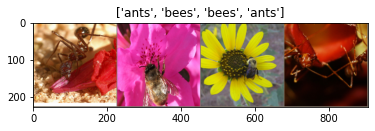

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Pega um lote de treinamento
inputs, classes = next(iter(dataloaders['train']))

# Faz um "grid" com as imagens
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Treinando o modelo

Agora, vamos escrever uma função geral para treinar um modelo. Aqui, ilustraremos:

* Agendando a taxa de aprendizado
* Salvando o melhor modelo

A seguir, o 'scheduler' de parâmetros é um objeto do 'scheduler' LR de torch.optim.lr_scheduler.

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Época {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Cada época tem uma fase de treino e validação
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Modelo em treinamento
            else:
                model.eval()   # Modelo em avaliação

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zera o gradiente do otimizador
                optimizer.zero_grad()

                # Analisa somente as perdas se for no treinamento
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 'loss.backward()' + 'optimizer.step()' somente no treinamento
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estatisticas
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Perda: {:.4f} Precisão: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Copia o modelo
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Treinamento completo em {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Melhor precisão: {:4f}'.format(best_acc))

    # Carrega os pesos do melhor modelo
    model.load_state_dict(best_model_wts)
    return model

###Visualizando as previsões do modelo

Função genérica para exibir previsões para algumas imagens

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

###Ajustando a ConvNet

Carregue um modelo pré-treinado e redefina a camada final totalmente conectada. Os modelos pré-treinados podem ser encontrados [aqui](https://pytorch.org/docs/stable/torchvision/models.html)

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Aqui o tamanho de cada amostra de saída é definido como 2.
# Alternativamente, pode ser generalizado para nn.Linear(num_ftrs, len (class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe que todos os parâmetros estão sendo otimizados
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decai a taxa de aprendizado por um fator de 0,1 a cada 7 épocas
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


###Treinar e avaliar

Na CPU deve demorar entre 15 e 25 minutos. Na GPU, leva menos de um minuto.

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=2)

Época 0/1
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Perda: 0.6190 Precisão: 0.6926
val Perda: 0.2680 Precisão: 0.8954

Época 1/1
----------
train Perda: 0.5515 Precisão: 0.7992
val Perda: 0.3666 Precisão: 0.8497

Treinamento completo em 0m 7s
Melhor precisão: 0.895425


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


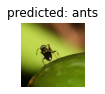

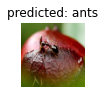

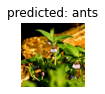

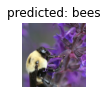

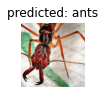

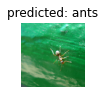

In [ ]:
visualize_model(model_ft)

### ConvNet como extrator de recurso fixo

Aqui, precisamos congelar toda a rede, exceto a camada final. Precisamos definir 'requires_grad == False' para congelar os parâmetros para que os gradientes não sejam computados em 'backward()'.

Você pode ler mais sobre isso na documentação [aqui](https://pytorch.org/docs/master/notes/autograd.html).

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parâmetros de módulos recém-construídos têm requires_grad = True por padrão
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe que apenas os parâmetros da camada final estão sendo otimizados ao contrario de antes.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decai a taxa de aprendizado por um fator de 0,1 a cada 7 épocas
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

###Treinar e avaliar

Na CPU, isso levará cerca de metade do tempo em comparação com o cenário anterior. Isso é esperado, pois os gradientes não precisam ser computados para a maior parte da rede. No entanto, o passe pela rede precisa ser calculado.

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=2)

Época 0/1
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Perda: 0.6586 Precisão: 0.6639
val Perda: 0.2040 Precisão: 0.9477

Época 1/1
----------
train Perda: 0.4513 Precisão: 0.7828
val Perda: 0.1746 Precisão: 0.9477

Treinamento completo em 0m 7s
Melhor precisão: 0.947712


In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

### Modificando o classificador da rede

Também podemos alterar todo o classificador de um modelo e criar o nosso, porém ele será treinado do "zero". Para modificar o classificador de um modelo podemos usar o seguinte código:

In [ ]:
model = models.vgg13(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(nn.Linear(25088, 2048),
                                 nn.ReLU(inplace=True),
                                 nn.Dropout(0.5),
                                 nn.Linear(2048, 2048),
                                 nn.ReLU(inplace=True),
                                 nn.Dropout(0.5),
                                 nn.Linear(2048, 10))

print(model)

Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /root/.cache/torch/hub/checkpoints/vgg13-19584684.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16):

### Salvando parâmetros

Caso você ja tenha treinado a rede neural com algumas classes especificas, será muito útil salvar as classes junto com o modelo treinado, assim pode usar o seguinte código:

In [ ]:
model.class_to_idx = image_datasets['train'].class_to_idx
torch.save(model.state_dict(), "model.pt")